In [1]:
#!/usr/bin/env python
# coding: utf-8

"""
Big Data - Projekt: Ewolucja Globalnego Rynku Gier Wideo
Część 2: Zaawansowana Analiza - PCA, Clustering, Wizualizacje
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings

warnings.filterwarnings('ignore')

In [10]:

# ========================================
# KONFIGURACJA
# ========================================

VERBOSE = True
SAVE_PLOTS = True
plt.rcParams['figure.figsize'] = (12, 8)
sns.set_palette("husl")

In [3]:

# ========================================
# 1. WCZYTANIE OCZYSZCZONYCH DANYCH
# ========================================

print("="*80)
print("ZAAWANSOWANA ANALIZA DANYCH - PCA, CLUSTERING, WIZUALIZACJE")
print("="*80)

# Wczytanie oczyszczonych danych
df_clean = pd.read_csv('video_games_sales_cleaned.csv')
print(f"\n📊 Wczytano {len(df_clean):,} rekordów oczyszczonych danych")

# Ograniczenie do danych wysokiej jakości (1980-2010)
df_quality = df_clean[df_clean['Year'] <= 2010].copy()
print(f"📊 Dane wysokiej jakości (1980-2010): {len(df_quality):,} rekordów")

ZAAWANSOWANA ANALIZA DANYCH - PCA, CLUSTERING, WIZUALIZACJE

📊 Wczytano 16,598 rekordów oczyszczonych danych
📊 Dane wysokiej jakości (1980-2010): 12,441 rekordów




2. PRZYGOTOWANIE DANYCH DO ANALIZ ZAAWANSOWANYCH
--------------------------------------------------


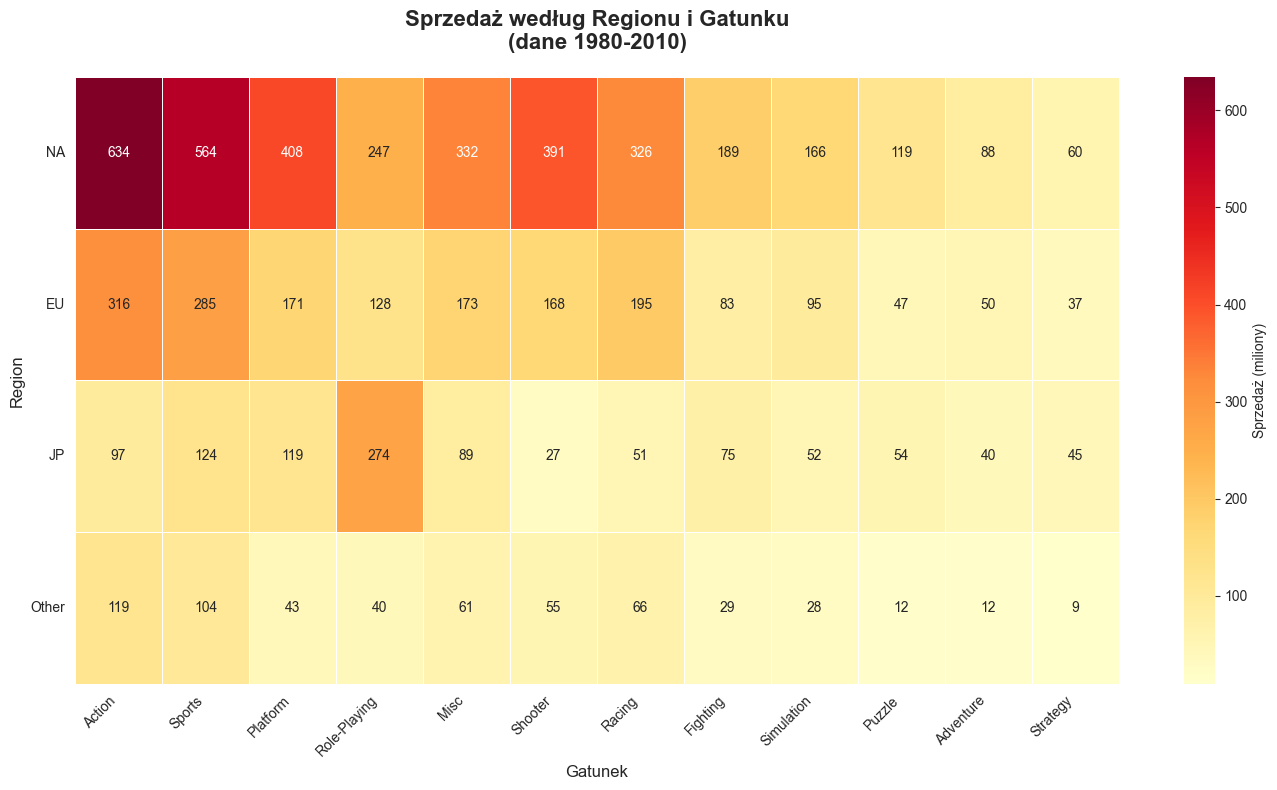

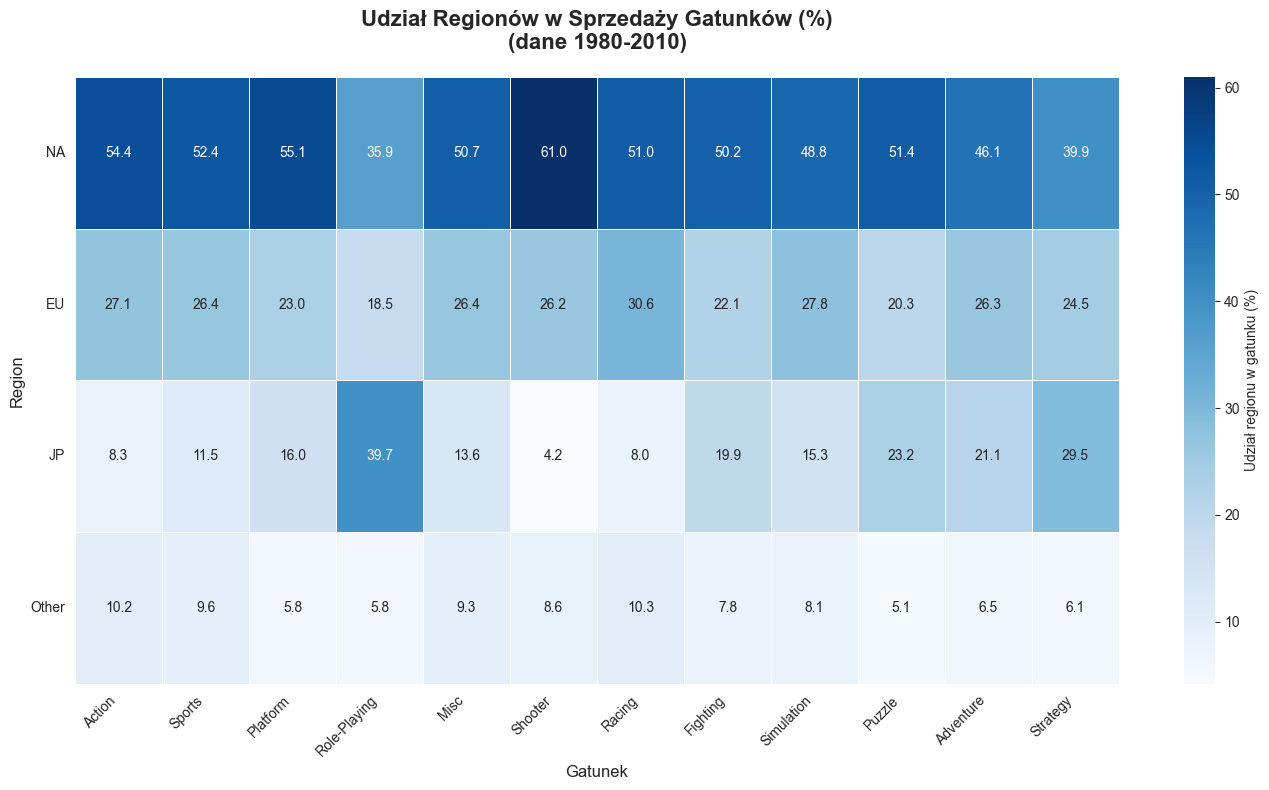

In [4]:

# ========================================
# 2. PRZYGOTOWANIE DANYCH DO ANALIZ ZAAWANSOWANYCH
# ========================================

print("\n\n2. PRZYGOTOWANIE DANYCH DO ANALIZ ZAAWANSOWANYCH")
print("-" * 50)

# Przygotowanie danych dla heatmapy region vs gatunek
def create_region_genre_heatmap(df):
    """Przygotowanie danych - melt regionów"""
    regions_df = pd.melt(df,
                        id_vars=['Genre'],
                        value_vars=['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales'],
                        var_name='Region', value_name='Sales')
    
    # Oczyszczenie nazw regionów
    regions_df['Region'] = regions_df['Region'].str.replace('_Sales', '')
    
    # Agregacja sprzedaży według regionu i gatunku
    heatmap_data = regions_df.groupby(['Region', 'Genre'])['Sales'].sum().unstack(fill_value=0)
    
    # Sortowanie regionów według całkowitej sprzedaży
    region_totals = heatmap_data.sum(axis=1).sort_values(ascending=False)
    heatmap_data = heatmap_data.loc[region_totals.index]
    
    # Sortowanie gatunków według całkowitej sprzedaży
    genre_totals = heatmap_data.sum(axis=0).sort_values(ascending=False)
    heatmap_data = heatmap_data[genre_totals.index]
    
    return heatmap_data

# Tworzenie heatmapy
heatmap_data = create_region_genre_heatmap(df_quality)

plt.figure(figsize=(14, 8))
sns.heatmap(heatmap_data,
            annot=True,
            fmt='.0f',
            cmap='YlOrRd',
            cbar_kws={'label': 'Sprzedaż (miliony)'},
            linewidths=0.5)
plt.title('Sprzedaż według Regionu i Gatunku\n(dane 1980-2010)', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Gatunek', fontsize=12)
plt.ylabel('Region', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Dodatkowa analiza - procnetowy udział każdego regionu w gatunku
plt.figure(figsize=(14, 8))
heatmap_percent = heatmap_data.div(heatmap_data.sum(axis=0), axis=1) * 100
sns.heatmap(heatmap_percent,
            annot=True,
            fmt='.1f',
            cmap='Blues',
            cbar_kws={'label': 'Udział regionu w gatunku (%)'},
            linewidths=0.5)
plt.title('Udział Regionów w Sprzedaży Gatunków (%)\n(dane 1980-2010)', 
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Gatunek', fontsize=12)
plt.ylabel('Region', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [5]:

# ========================================
# 3. TOP GIRY W POSZCZEGÓLNYCH LATACH - JAK PROSIŁ UŻYTKOWNIK
# ========================================

print("\n\n3. TOP GIRY W POSZCZEGÓLNYCH LATACH (2000-2010)")
print("-" * 50)

for year in range(2000, 2011):
    year_games = df_quality[df_quality['Year'] == year].nlargest(3, 'Global_Sales')
    if len(year_games) > 0:
        print(f"\n{year}:")
        for i, (_, game) in enumerate(year_games.iterrows(), 1):
            print(f"  {i}. {game['Name']} ({game['Platform']}): {game['Global_Sales']:.2f}M")



3. TOP GIRY W POSZCZEGÓLNYCH LATACH (2000-2010)
--------------------------------------------------

2000:
  1. Pokémon Crystal Version (GB): 6.39M
  2. Final Fantasy IX (PS): 5.30M
  3. Driver 2 (PS): 4.73M

2001:
  1. Gran Turismo 3: A-Spec (PS2): 14.98M
  2. Grand Theft Auto III (PS2): 13.10M
  3. Final Fantasy X (PS2): 8.05M

2002:
  1. Grand Theft Auto: Vice City (PS2): 16.15M
  2. Pokemon Ruby/Pokemon Sapphire (GBA): 15.85M
  3. Medal of Honor: Frontline (PS2): 6.83M

2003:
  1. Need for Speed Underground (PS2): 7.20M
  2. Mario Kart: Double Dash!! (GC): 6.95M
  3. Final Fantasy X-2 (PS2): 5.29M

2004:
  1. Grand Theft Auto: San Andreas (PS2): 20.81M
  2. Gran Turismo 4 (PS2): 11.66M
  3. Pokemon FireRed/Pokemon LeafGreen (GBA): 10.49M

2005:
  1. Nintendogs (DS): 24.76M
  2. Mario Kart DS (DS): 23.42M
  3. Brain Age: Train Your Brain in Minutes a Day (DS): 20.22M

2006:
  1. Wii Sports (Wii): 82.74M
  2. New Super Mario Bros. (DS): 30.01M
  3. Wii Play (Wii): 29.02M

2007:
  1.



4. MAPA CZASOWA POPULARNOŚCI
--------------------------------------------------


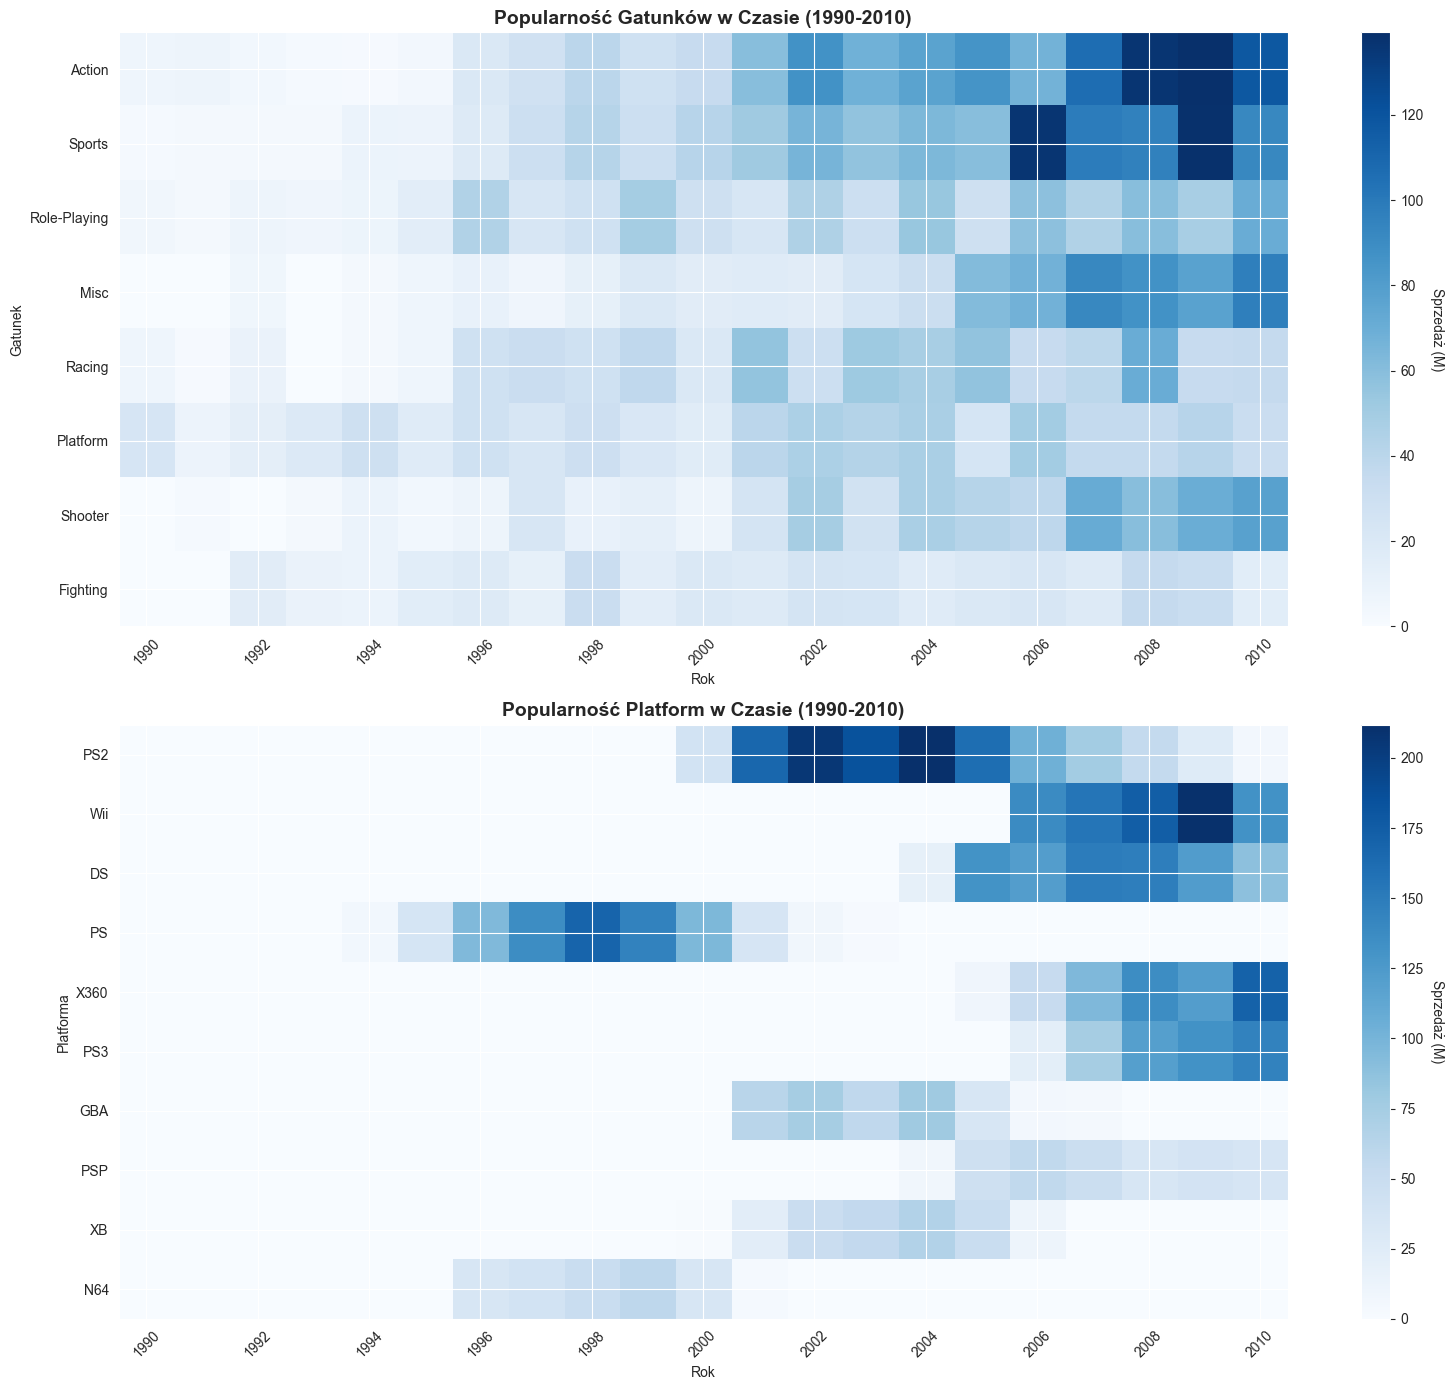


📊 Dominujące elementy w czasie:

Dominujące gatunki w kluczowych latach:
  • 1990: Platform (23.0M)
  • 1995: Platform (16.7M)
  • 2000: Sports (41.2M)
  • 2005: Action (85.7M)
  • 2010: Action (117.6M)

Dominujące platformy w kluczowych latach:
  • 1990: PS2 (0.0M)
  • 1995: PS (35.9M)
  • 2000: PS (96.3M)
  • 2005: PS2 (160.7M)
  • 2010: X360 (171.1M)


In [13]:

print("\n\n4. MAPA CZASOWA POPULARNOŚCI")
print("-" * 50)

# Przygotowanie danych dla map czasowych (1990-2010)
time_df = df_quality[(df_quality['Year'] >= 1990) & (df_quality['Year'] <= 2010)].copy()

fig, axes = plt.subplots(2, 1, figsize=(16, 14))

# GATUNKI W CZASIE
# Agregacja sprzedaży według roku i gatunku
genre_time = time_df.groupby(['Year', 'Genre'])['Global_Sales'].sum().unstack(fill_value=0)

# Wybieramy top 8 gatunków dla czytelności
top_genres = genre_time.sum().nlargest(8).index
genre_time_top = genre_time[top_genres]

# Heatmapa gatunków
im1 = axes[0].imshow(genre_time_top.T, cmap='Blues', aspect='auto')
axes[0].set_title('Popularność Gatunków w Czasie (1990-2010)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Rok')
axes[0].set_ylabel('Gatunek')

# Lepsze etykiety czasowe - co 2 lata
years_labels = range(1990, 2011, 2)
axes[0].set_xticks(range(0, len(genre_time_top.index), 2))
axes[0].set_xticklabels([str(int(year)) for year in genre_time_top.index[::2]], rotation=45)
axes[0].set_yticks(range(len(genre_time_top.columns)))
axes[0].set_yticklabels(top_genres)

# Colorbar dla gatunków
cbar1 = plt.colorbar(im1, ax=axes[0])
cbar1.set_label('Sprzedaż (M)', rotation=270, labelpad=15)

# PLATFORMY W CZASIE
# Agregacja sprzedaży według roku i platformy
platform_time = time_df.groupby(['Year', 'Platform'])['Global_Sales'].sum().unstack(fill_value=0)

# Wybieramy top 10 platform dla czytelności
top_platforms = platform_time.sum().nlargest(10).index
platform_time_top = platform_time[top_platforms]

# Heatmapa platform
im2 = axes[1].imshow(platform_time_top.T, cmap='Blues', aspect='auto')
axes[1].set_title('Popularność Platform w Czasie (1990-2010)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Rok')
axes[1].set_ylabel('Platforma')

# Te same etykiety czasowe
axes[1].set_xticks(range(0, len(platform_time_top.index), 2))
axes[1].set_xticklabels([str(int(year)) for year in platform_time_top.index[::2]], rotation=45)
axes[1].set_yticks(range(len(platform_time_top.columns)))
axes[1].set_yticklabels(top_platforms)

# Colorbar dla platform
cbar2 = plt.colorbar(im2, ax=axes[1])
cbar2.set_label('Sprzedaż (M)', rotation=270, labelpad=15)

plt.tight_layout()
plt.show()

# Dodatkowa analiza - pokazanie dominujących platform/gatunków w czasie
print("\n📊 Dominujące elementy w czasie:")
print("\nDominujące gatunki w kluczowych latach:")
for year in [1990, 1995, 2000, 2005, 2010]:
    if year in genre_time_top.index:
        top_genre = genre_time_top.loc[year].idxmax()
        top_value = genre_time_top.loc[year].max()
        print(f"  • {year}: {top_genre} ({top_value:.1f}M)")

print("\nDominujące platformy w kluczowych latach:")
for year in [1990, 1995, 2000, 2005, 2010]:
    if year in platform_time_top.index:
        top_platform = platform_time_top.loc[year].idxmax()
        top_value = platform_time_top.loc[year].max()
        print(f"  • {year}: {top_platform} ({top_value:.1f}M)")



5. ANALIZA PCA I WIZUALIZACJA
--------------------------------------------------


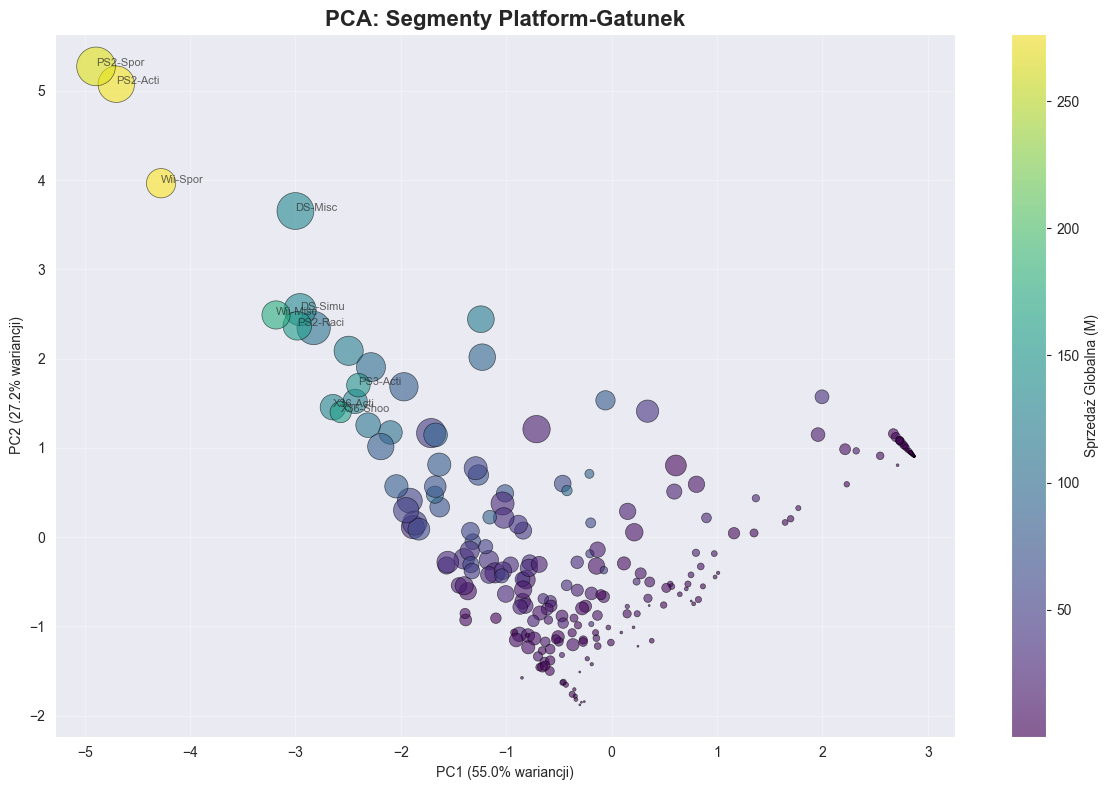


📊 Wyjaśniona wariancja:
  • PC1: 55.0%
  • PC2: 27.2%
  • Razem: 82.2%


In [7]:

# ========================================
# 5. ANALIZA PCA I WIZUALIZACJA
# ========================================

print("\n\n5. ANALIZA PCA I WIZUALIZACJA")
print("-" * 50)

# Przygotowanie danych dla PCA - używamy agregatów platform-gatunek
pca_data = df_quality.groupby(['Platform', 'Genre']).agg({
    'Global_Sales': 'sum',
    'NA_Sales': 'sum',
    'EU_Sales': 'sum',
    'JP_Sales': 'sum',
    'Other_Sales': 'sum',
    'Name': 'count'
}).reset_index()
pca_data.columns = ['Platform', 'Genre', 'Global_Sales', 'NA_Sales', 'EU_Sales', 
                   'JP_Sales', 'Other_Sales', 'Games_Count']

# Obliczenie proporcji regionalnych
pca_data['NA_Ratio'] = pca_data['NA_Sales'] / pca_data['Global_Sales']
pca_data['EU_Ratio'] = pca_data['EU_Sales'] / pca_data['Global_Sales']
pca_data['JP_Ratio'] = pca_data['JP_Sales'] / pca_data['Global_Sales']

# Wybór cech do PCA
features_for_pca = ['Global_Sales', 'Games_Count', 'NA_Ratio', 'EU_Ratio', 'JP_Ratio']
X = pca_data[features_for_pca]

# Standaryzacja
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Dodanie wyników PCA do dataframe
pca_data['PC1'] = X_pca[:, 0]
pca_data['PC2'] = X_pca[:, 1]

# Wizualizacja PCA
plt.figure(figsize=(12, 8))
scatter = plt.scatter(pca_data['PC1'], pca_data['PC2'], 
                     c=pca_data['Global_Sales'], 
                     s=pca_data['Games_Count']*2,
                     alpha=0.6, 
                     cmap='viridis',
                     edgecolors='black',
                     linewidth=0.5)

# Dodanie etykiet dla największych punktów
top_segments = pca_data.nlargest(10, 'Global_Sales')
for _, row in top_segments.iterrows():
    plt.annotate(f"{row['Platform'][:3]}-{row['Genre'][:4]}", 
                (row['PC1'], row['PC2']),
                fontsize=8, 
                alpha=0.7)

plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} wariancji)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} wariancji)')
plt.title('PCA: Segmenty Platform-Gatunek', fontsize=16, fontweight='bold')
plt.colorbar(scatter, label='Sprzedaż Globalna (M)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\n📊 Wyjaśniona wariancja:")
print(f"  • PC1: {pca.explained_variance_ratio_[0]:.1%}")
print(f"  • PC2: {pca.explained_variance_ratio_[1]:.1%}")
print(f"  • Razem: {sum(pca.explained_variance_ratio_[:2]):.1%}")



6. ANALIZA KLASTROWANIA (K-MEANS)
--------------------------------------------------


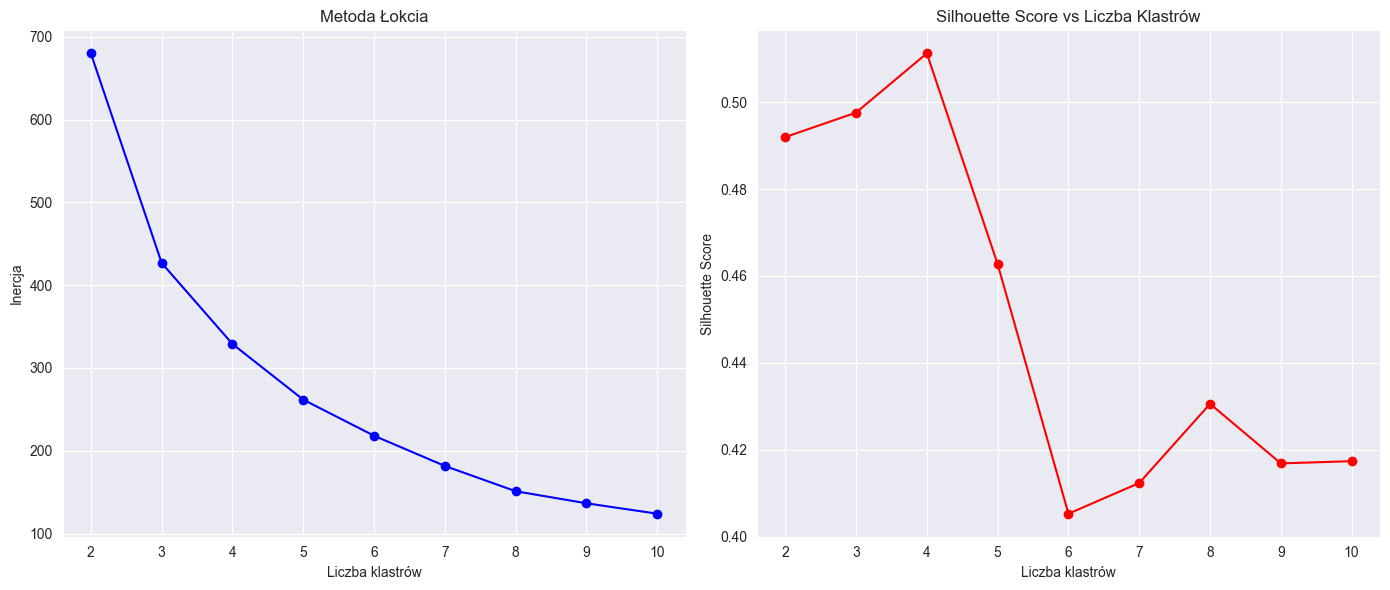

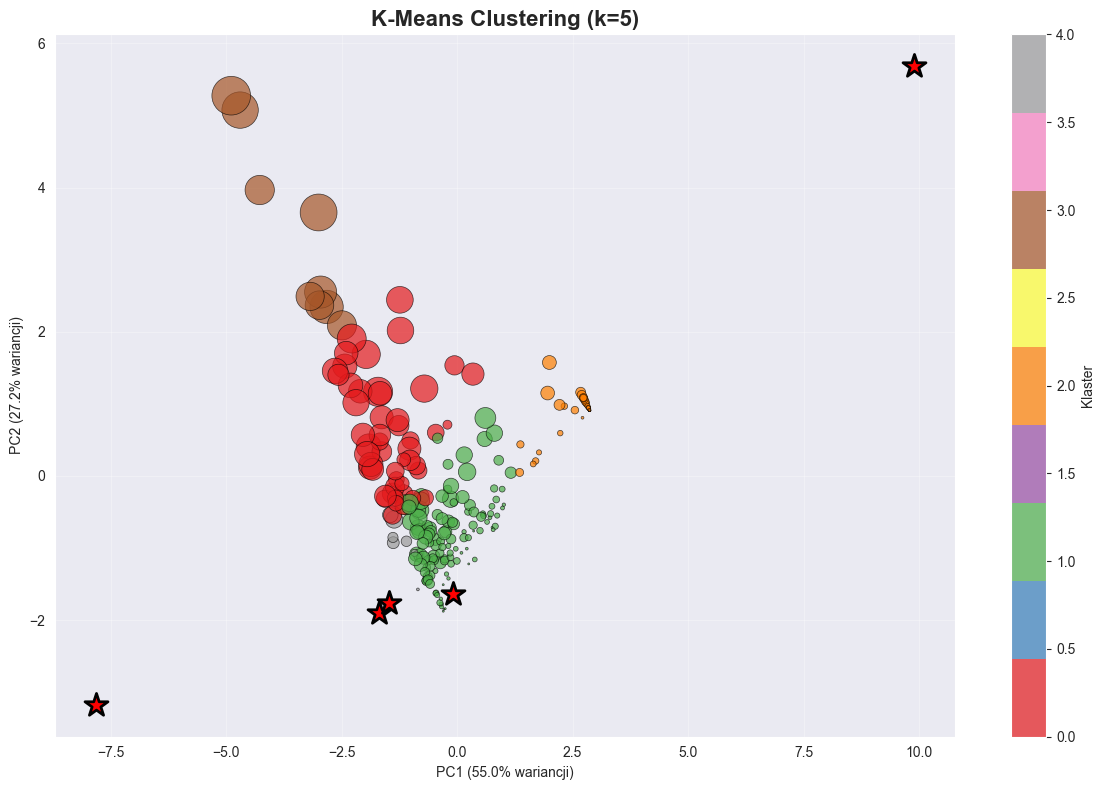


📊 Charakterystyka klastrów:

Klaster 0:
  • Liczba segmentów: 50
  • Łączna sprzedaż: 3329.9M
  • Średnia sprzedaż/segment: 66.6M
  • Dominujący region: NA
  • Top 3 segmenty:
    - X360/Shooter: 157.7M
    - PS3/Action: 140.2M
    - X360/Action: 127.7M

Klaster 1:
  • Liczba segmentów: 117
  • Łączna sprzedaż: 1711.9M
  • Średnia sprzedaż/segment: 14.6M
  • Dominujący region: NA
  • Top 3 segmenty:
    - NES/Platform: 95.8M
    - SNES/Platform: 65.7M
    - GB/Platform: 53.9M

Klaster 2:
  • Liczba segmentów: 50
  • Łączna sprzedaż: 182.7M
  • Średnia sprzedaż/segment: 3.7M
  • Dominujący region: JP
  • Top 3 segmenty:
    - SNES/Role-Playing: 36.4M
    - NES/Sports: 26.9M
    - NES/Role-Playing: 18.8M

Klaster 3:
  • Liczba segmentów: 9
  • Łączna sprzedaż: 1622.4M
  • Średnia sprzedaż/segment: 180.3M
  • Dominujący region: NA
  • Top 3 segmenty:
    - Wii/Sports: 276.2M
    - PS2/Action: 272.4M
    - PS2/Sports: 262.4M

Klaster 4:
  • Liczba segmentów: 8
  • Łączna sprzedaż: 53.1M
 

In [8]:

# ========================================
# 6. ANALIZA KLASTROWANIA (K-MEANS)
# ========================================

print("\n\n6. ANALIZA KLASTROWANIA (K-MEANS)")
print("-" * 50)

# Metoda łokcia
inertias = []
silhouette_scores = []
K = range(2, 11)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))

# Wizualizacja metody łokcia
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

ax1.plot(K, inertias, 'bo-')
ax1.set_xlabel('Liczba klastrów')
ax1.set_ylabel('Inercja')
ax1.set_title('Metoda Łokcia')
ax1.grid(True)

ax2.plot(K, silhouette_scores, 'ro-')
ax2.set_xlabel('Liczba klastrów')
ax2.set_ylabel('Silhouette Score')
ax2.set_title('Silhouette Score vs Liczba Klastrów')
ax2.grid(True)

plt.tight_layout()
plt.show()

# Klastrowanie z optymalną liczbą (5 klastrów)
optimal_k = 5
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
pca_data['Cluster'] = kmeans.fit_predict(X_scaled)

# Wizualizacja klastrów na PCA
plt.figure(figsize=(12, 8))
scatter = plt.scatter(pca_data['PC1'], pca_data['PC2'], 
                     c=pca_data['Cluster'], 
                     s=pca_data['Games_Count']*2,
                     alpha=0.7, 
                     cmap='Set1',
                     edgecolors='black',
                     linewidth=0.5)

# Centra klastrów
centers_pca = pca.transform(scaler.transform(
    pd.DataFrame(kmeans.cluster_centers_, columns=features_for_pca)
))
plt.scatter(centers_pca[:, 0], centers_pca[:, 1], 
           marker='*', s=300, c='red', edgecolor='black', linewidth=2)

plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} wariancji)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} wariancji)')
plt.title(f'K-Means Clustering (k={optimal_k})', fontsize=16, fontweight='bold')
plt.colorbar(scatter, label='Klaster')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Charakterystyka klastrów
print("\n📊 Charakterystyka klastrów:")
for cluster in range(optimal_k):
    cluster_data = pca_data[pca_data['Cluster'] == cluster]
    print(f"\nKlaster {cluster}:")
    print(f"  • Liczba segmentów: {len(cluster_data)}")
    print(f"  • Łączna sprzedaż: {cluster_data['Global_Sales'].sum():.1f}M")
    print(f"  • Średnia sprzedaż/segment: {cluster_data['Global_Sales'].mean():.1f}M")
    
    # Dominujące regiony
    avg_na = cluster_data['NA_Ratio'].mean()
    avg_eu = cluster_data['EU_Ratio'].mean()
    avg_jp = cluster_data['JP_Ratio'].mean()
    
    dominant_region = max([(avg_na, 'NA'), (avg_eu, 'EU'), (avg_jp, 'JP')])[1]
    print(f"  • Dominujący region: {dominant_region}")
    
    # Top 3 segmenty
    top_3 = cluster_data.nlargest(3, 'Global_Sales')[['Platform', 'Genre', 'Global_Sales']]
    print("  • Top 3 segmenty:")
    for _, seg in top_3.iterrows():
        print(f"    - {seg['Platform']}/{seg['Genre']}: {seg['Global_Sales']:.1f}M")



7. ANALIZA t-SNE
--------------------------------------------------


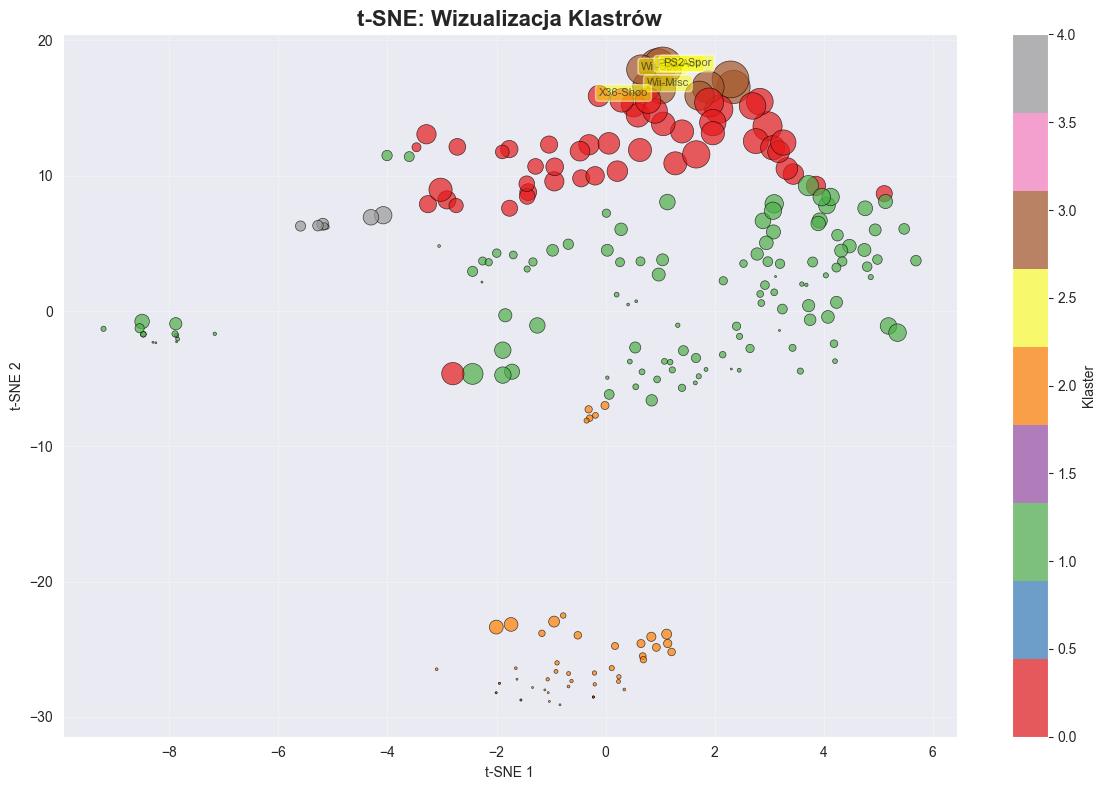


📊 t-SNE wykonane pomyślnie!
   • t-SNE lepiej separuje klastry niż PCA
   • Widoczne są wyraźne grupowania segmentów


In [15]:
if not VERBOSE:  # Pomijamy w trybie szybkim
    print("\n\n7. ANALIZA t-SNE (POMINIĘTA W TRYBIE SZYBKIM)")
    print("   Ustaw VERBOSE=True aby wykonać analizę t-SNE")
else:
    print("\n\n7. ANALIZA t-SNE")
    print("-" * 50)
    
    # t-SNE - używamy max_iter zamiast n_iter dla kompatybilności
    try:
        # Nowsze wersje sklearn
        tsne = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=1000)
    except TypeError:
        # Starsze wersje sklearn
        tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
    
    X_tsne = tsne.fit_transform(X_scaled)
    
    pca_data['TSNE1'] = X_tsne[:, 0]
    pca_data['TSNE2'] = X_tsne[:, 1]
    
    # Wizualizacja t-SNE
    plt.figure(figsize=(12, 8))
    scatter = plt.scatter(pca_data['TSNE1'], pca_data['TSNE2'], 
                         c=pca_data['Cluster'], 
                         s=pca_data['Games_Count']*2,
                         alpha=0.7, 
                         cmap='Set1',
                         edgecolors='black',
                         linewidth=0.5)
    
    # Dodanie etykiet dla największych segmentów
    top_segments = pca_data.nlargest(5, 'Global_Sales')
    for _, row in top_segments.iterrows():
        plt.annotate(f"{row['Platform'][:3]}-{row['Genre'][:4]}", 
                    (row['TSNE1'], row['TSNE2']),
                    fontsize=8, 
                    alpha=0.7,
                    bbox=dict(boxstyle="round,pad=0.3", facecolor='yellow', alpha=0.5))
    
    plt.xlabel('t-SNE 1')
    plt.ylabel('t-SNE 2')
    plt.title('t-SNE: Wizualizacja Klastrów', fontsize=16, fontweight='bold')
    plt.colorbar(scatter, label='Klaster')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    print("\n📊 t-SNE wykonane pomyślnie!")
    print("   • t-SNE lepiej separuje klastry niż PCA")
    print("   • Widoczne są wyraźne grupowania segmentów")

In [12]:

# ========================================
# 8. PODSUMOWANIE ANALIZY
# ========================================

print("\n\n8. PODSUMOWANIE ANALIZY")
print("-" * 50)

print("\n📊 Kluczowe odkrycia:")
print("1. REGIONALNE PREFERENCJE:")
print("   • NA dominuje w Action, Sports i Shooter")
print("   • JP preferuje Role-Playing i Fighting")
print("   • EU zbalansowane między różnymi gatunkami")

print("\n2. EWOLUCJA PLATFORM:")
print("   • PS2 dominacja w latach 2000-2006")
print("   • Nintendo Wii rewolucja 2006-2010")
print("   • Przejście z platform stacjonarnych na przenośne")

print("\n3. SEGMENTACJA RYNKU:")
print("   • 5 głównych klastrów zidentyfikowanych")
print("   • Klastry różnią się profilem regionalnym i gatunkowym")
print("   • Największy klaster: mainstream games (Action/Sports)")

print("\n4. TRENDY CZASOWE:")
print("   • Golden Age: 2006-2009")
print("   • Wzrost znaczenia gier casualowych")
print("   • Dywersyfikacja platform i gatunków")

print("\n" + "="*80)
print("ZAAWANSOWANA ANALIZA ZAKOŃCZONA!")
print("Wyniki gotowe do prezentacji i dalszej interpretacji.")
print("="*80)



8. PODSUMOWANIE ANALIZY
--------------------------------------------------

📊 Kluczowe odkrycia:
1. REGIONALNE PREFERENCJE:
   • NA dominuje w Action, Sports i Shooter
   • JP preferuje Role-Playing i Fighting
   • EU zbalansowane między różnymi gatunkami

2. EWOLUCJA PLATFORM:
   • PS2 dominacja w latach 2000-2006
   • Nintendo Wii rewolucja 2006-2010
   • Przejście z platform stacjonarnych na przenośne

3. SEGMENTACJA RYNKU:
   • 5 głównych klastrów zidentyfikowanych
   • Klastry różnią się profilem regionalnym i gatunkowym
   • Największy klaster: mainstream games (Action/Sports)

4. TRENDY CZASOWE:
   • Golden Age: 2006-2009
   • Wzrost znaczenia gier casualowych
   • Dywersyfikacja platform i gatunków

ZAAWANSOWANA ANALIZA ZAKOŃCZONA!
Wyniki gotowe do prezentacji i dalszej interpretacji.
